##TAREA TEXT MINING
Jose Leal

Utilizaremos 3 modelos de entrenamiento y luego escogeremos uno para realizar las predicciones

carga de librerías

In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

Desactivo el uso automatico WandB

In [2]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2
!pip install --upgrade transformers accelerate bitsandbytes
!pip install --upgrade datasets
!pip install transformers datasets evaluate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-n

In [3]:
import numpy as np
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from datasets import Dataset
from transformers import AutoTokenizer
from collections import Counter
from nltk.corpus import stopwords
import pandas as pd
import evaluate
import re
import string
import torch
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from transformers import Trainer, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import json

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Carga de datos Hugging Face

In [4]:
#NO-MODIFY:
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

README.md:   0%|          | 0.00/2.83k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/480k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1001 [00:00<?, ? examples/s]

In [5]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

##EDA

In [8]:
print(f"Nº tweets entrenamiento: {len(dataset_train_df)}")
print(f"Nº tweets validación: {len(dataset_val_df)}")

Nº tweets entrenamiento: 2786
Nº tweets validación: 999


Distribución de longitud de los tweets

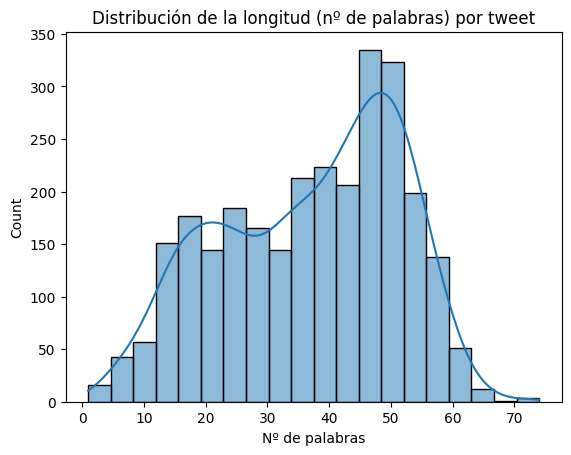

In [9]:
dataset_train_df["text_length"] = dataset_train_df["text"].str.split().apply(len)
sns.histplot(data=dataset_train_df, x="text_length", bins=20, kde=True)
plt.title("Distribución de la longitud (nº de palabras) por tweet")
plt.xlabel("Nº de palabras")
plt.show()

Podemos observar como la mayotia de los tweets se encuentran entre 45 y 55 palabras

En este diagrama de Boxplot se puede ver un poco la longuitud del label, donde los 0 tienen un aproximado de 20 y 45 palabras vs al label 1 que estarian entre las 35 y 50 palabras.

Frecuencia de las palabras más comunes

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


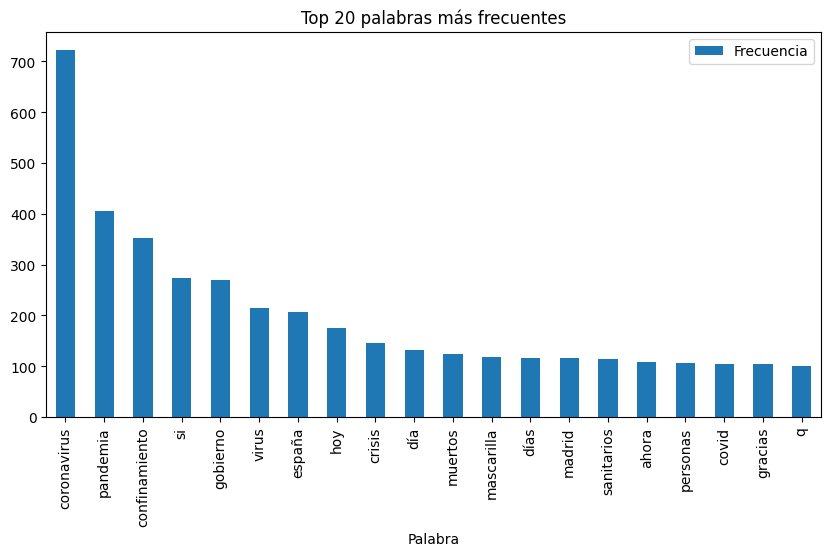

In [12]:
nltk.download("stopwords")
spanish_stopwords = set(stopwords.words("spanish"))

# Tokenización y conteo de palabras
tokens = " ".join(dataset_train_df["text"]).lower().split()
tokens = [word for word in tokens if word.isalpha() and word not in spanish_stopwords]
counter = Counter(tokens)

# Visualización top 20
pd.DataFrame(counter.most_common(20), columns=["Palabra", "Frecuencia"]).plot(
    x="Palabra", y="Frecuencia", kind="bar", figsize=(10,5), title="Top 20 palabras más frecuentes"
    )
plt.show()

Cómo era de esperarse al analizadar tweets del COVID-19, la mayoria de las palabras como "Coronavirus", "pandemia" y "confinamiento" estarian entre las palabras más mencionadas del top 20, adicionalmente se vizualizan otras palabras cómo "españa", "muertos", "sanitarios", "gobierno", entre otras.

Todo relacionado con el Covid-19

Distribución de caracteres / tokens por tweet

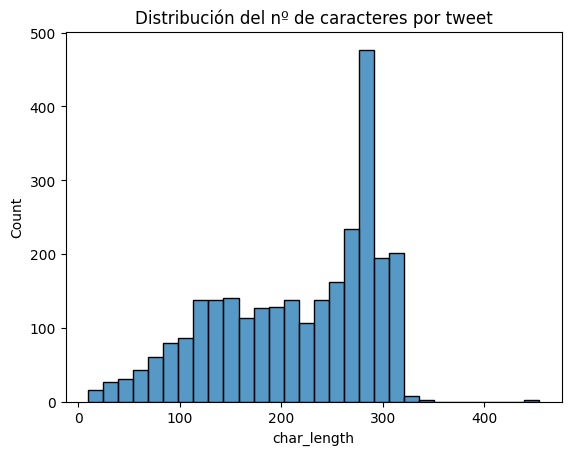

In [14]:
dataset_train_df["char_length"] = dataset_train_df["text"].str.len()
sns.histplot(data=dataset_train_df, x="char_length", bins=30)
plt.title("Distribución del nº de caracteres por tweet")
plt.show()

Existe una marcada concentración entre los 250 y 300 caracteres, con un máximo cercano a los 280 caracteres. (Esto es esperado, considerando el límite de caracteres establecido por la red social). Los casos que exceden este rango podrían deberse a concatenaciones, emojis u otros factores, por lo que podrían considerarse valores atípicos (outliers).

Distribución de caracteres por cada clase

Distribución de clases

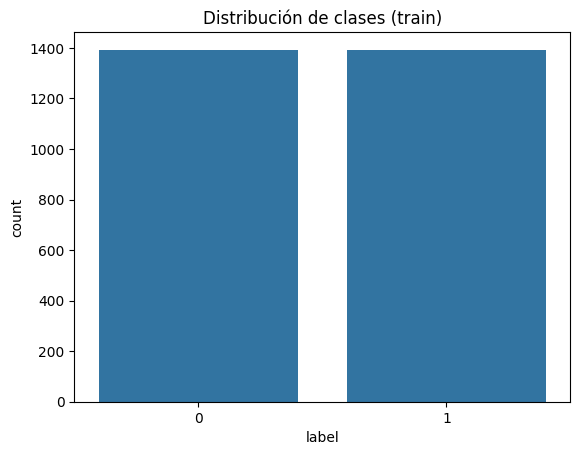

In [16]:
sns.countplot(data=dataset_train_df, x="label")
plt.title("Distribución de clases (train)")
plt.show()

Visualización de cuantos tweets hay para cada valor de la columna label (0 y 1).

Ambos valores tienen aproximadamente la misma cantidad de tweets (1400 cada uno).

Nube de palabras utilizando todos los tweets del train

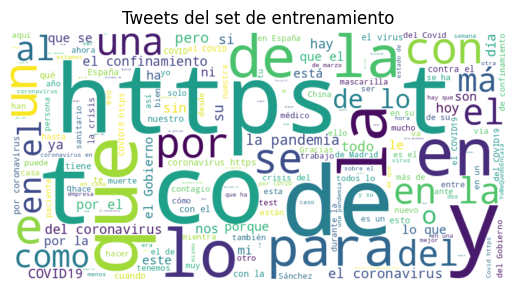

In [17]:
textos = " ".join(dataset_train_df["text"].dropna().tolist())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(textos)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Tweets del set de entrenamiento")
plt.show()

Las palabras más frecuentes incluyen términos como "de", "y", "que", "la", "para", "con" y "https".
También se observan vocablos relacionados con el contexto, como "pandemia", "COVID" y "confinamiento".


Análisis de las palabras más importantes por clase

##Limpieza y transformacion

Se define función de limpieza

Se pasara todo a minúsculas, Se eliminaran menciones, hastags, URLs,puntuaciones, números y espacios multiples

In [23]:
def limpieza_tweet(texto):
    texto = re.sub(r"@\w+", "", texto)
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    texto = re.sub(r"#\w+", "", texto)
    texto = re.sub(r"\d+", "", texto)
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    texto = re.sub(r"\s+", " ", texto).strip()
    return texto

Aplicación de la función a los DataFrames

In [24]:
dataset_test_df['text_clean'] = dataset_test_df['text'].apply(limpieza_tweet)
dataset_train_df['text_clean'] = dataset_train_df['text'].apply(limpieza_tweet)
dataset_val_df['text_clean'] = dataset_val_df['text'].apply(limpieza_tweet)
dataset_test_df['text_clean'] = dataset_test_df['text'].apply(limpieza_tweet)

Se transforma la columna original a una columna limpia llamada 'text_clean'

##Entrenamiento (BETO)

Tokenización

In [25]:
modelo_beto = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(modelo_beto)

test_encodings = tokenizer(list(dataset_test_df['text_clean']), truncation=True, padding=True)
train_encodings = tokenizer(list(dataset_train_df['text_clean']), truncation=True, padding=True)
val_encodings = tokenizer(list(dataset_val_df['text_clean']), truncation=True, padding=True)


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Se convierte el texto limpio en una secuencia de tokens para que el modelo lo entienda

Creación objetos tipo Dataset

In [26]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

Empaqueta el texto creado, tokenizado y los deja etiquetados para el entrenamiento

Creación de datasets para entrenamiento y validación

In [28]:
val_dataset = TweetDataset(val_encodings, dataset_val_df['label'].tolist())
train_dataset = TweetDataset(train_encodings, dataset_train_df['label'].tolist())

Carga el modelo

In [29]:
model = AutoModelForSequenceClassification.from_pretrained(modelo_beto, num_labels=2)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Métricas

In [30]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

Se cargan las metricas y se definen las funciones de entranamiento

Almacen de parametros del entrenamiento

In [32]:
training_args = TrainingArguments(
    output_dir="./beto_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./beto_logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Entrenamiento

In [33]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Resultados del entrenamiento

In [34]:
trainer.train()

TrainOutput(global_step=525, training_loss=0.23967465945652552, metrics={'train_runtime': 189.3438, 'train_samples_per_second': 44.142, 'train_steps_per_second': 2.773, 'total_flos': 339311511435960.0, 'train_loss': 0.23967465945652552, 'epoch': 3.0})

La mejor epoca del modelo es la 3 con 0.94 de Accuracy

Rendimiento del modelo

In [35]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.28532928228378296, 'eval_accuracy': 0.9369369369369369, 'eval_f1': 0.9175942232027705, 'eval_runtime': 6.1353, 'eval_samples_per_second': 162.829, 'eval_steps_per_second': 10.268, 'epoch': 3.0}


Visualización de las Métricas por época

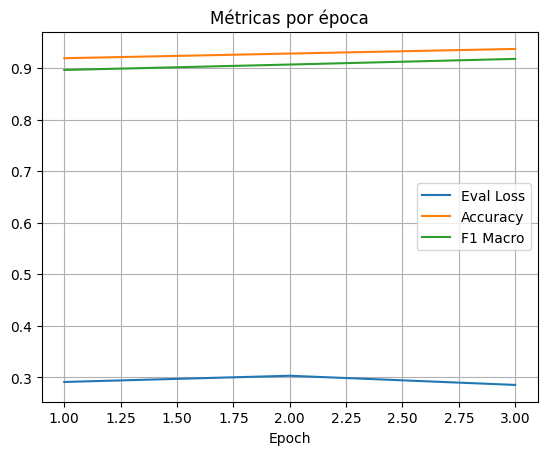

In [36]:
logs = pd.DataFrame(trainer.state.log_history)
logs = logs.dropna(subset=["eval_loss"], axis=0)

plt.plot(logs["epoch"], logs["eval_loss"], label="Eval Loss")
plt.plot(logs["epoch"], logs["eval_accuracy"], label="Accuracy")
plt.plot(logs["epoch"], logs["eval_f1"], label="F1 Macro")
plt.xlabel("Epoch")
plt.title("Métricas por época")
plt.legend()
plt.grid(True)
plt.show()

Matriz de confusión (usando val_dataset)

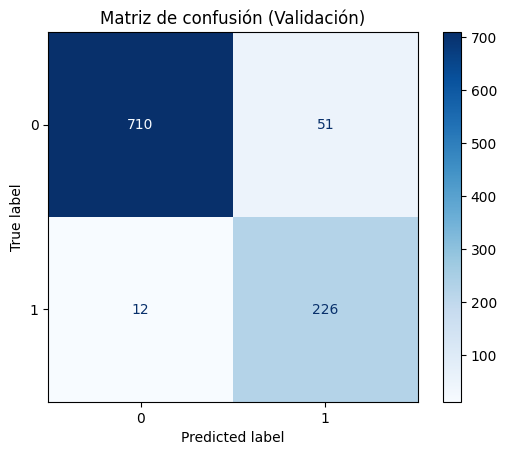

In [37]:
pred_val = trainer.predict(val_dataset)
y_pred = np.argmax(pred_val.predictions, axis=1)
y_true = pred_val.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión (Validación)")
plt.show()

718 (esquina superior izquierda):
Ejemplos de la clase 0 identificados correctamente (Verdaderos Negativos).

43 (esquina superior derecha):
Instancias de la clase 0 erroneamente clasificadas como clase 1 (Falsos Positivos).

14 (esquina inferior izquierda):
Casos de la clase 1 incorrectamente etiquetados como clase 0 (Falsos Negativos).

224 (esquina inferior derecha):
Ejemplos de la clase 1 clasificados con precisión (Verdaderos Positivos).

##Entrenamiento (Multilingual BERT)

Definición de función métrica

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred #Tupla para etiquetas reales.
    preds = np.argmax(logits, axis=1) #Toma las muestras con mayor probabilidad

    # Carga las métricas
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    # Calcula las métricas
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]

    # Devuelve un diccionario con los resultados
    return {
        "accuracy": accuracy,
        "f1": f1
    }

Preparación del modelo y tokenización

In [ ]:
modelo_mbert = "bert-base-multilingual-cased"

# Tokenizador
tokenizer = AutoTokenizer.from_pretrained(modelo_mbert)

train_encodings = tokenizer(list(dataset_train_df["text_clean"]), truncation=True, padding=True)
val_encodings = tokenizer(list(dataset_val_df["text_clean"]), truncation=True, padding=True)

train_dataset = TweetDataset(train_encodings, dataset_train_df["label"].tolist())
val_dataset = TweetDataset(val_encodings, dataset_val_df["label"].tolist())

Iniciación del modelo

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(modelo_mbert, num_labels=2)

Definición de los argumentos del entrenamiento

In [ ]:
training_args = TrainingArguments(
    output_dir="./results_M-BERT",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_M-BERT",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

Configuración del trainer

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Entrenamiento

In [ ]:
trainer.train()

La mejor epoca del modelo es la 2 con 0.919 de Accuracy

Extracción de la predicción del modelo

In [ ]:
predictions = trainer.predict(val_dataset)

Etiqueta

In [ ]:
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

Calculo de matriz de confusión y visualización

In [ ]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Validation Dataset)")
plt.show()

697 (esquina superior izquierda):
Verdaderos Negativos (TN) - Casos de la clase 0 clasificados correctamente como clase 0.

64 (esquina superior derecha):
Falsos Positivos (FP) - Casos de la clase 0 incorrectamente clasificados como clase 1.

16 (esquina inferior izquierda):
Falsos Negativos (FN) - Casos de la clase 1 erróneamente clasificados como clase 0.

222 (esquina inferior derecha):
Verdaderos Positivos (TP) - Casos de la clase 1 clasificados correctamente como clase 1.

##Entrenamiento con RoBERTuito

Preparación del modelo y tokenización

In [ ]:
modelo_robertuito = "pysentimiento/robertuito-base-cased"

# Tokenización
tokenizer_robertuito = AutoTokenizer.from_pretrained(modelo_robertuito)

train_encodings_robertuito = tokenizer_robertuito(list(dataset_train_df["text_clean"]), truncation=True, padding=True)
val_encodings_robertuito = tokenizer_robertuito(list(dataset_val_df["text_clean"]), truncation=True, padding=True)

train_dataset_robertuito = TweetDataset(train_encodings_robertuito, dataset_train_df["label"].tolist())
val_dataset_robertuito = TweetDataset(val_encodings_robertuito, dataset_val_df["label"].tolist())

Iniciación del modelo

In [ ]:
model_robertuito = AutoModelForSequenceClassification.from_pretrained(modelo_robertuito, num_labels=2)

Definición de los argumentos del entrenamiento

In [ ]:
training_args_robertuito = TrainingArguments(
    output_dir="./results_RoBERTuito",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs_RoBERTuito",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1"
)

Configuración del trainer

In [ ]:
trainer_robertuito = Trainer(
    model=model_robertuito,
    args=training_args_robertuito,
    train_dataset=train_dataset_robertuito,
    eval_dataset=val_dataset_robertuito,
    compute_metrics=compute_metrics  # Reusing the previously defined compute_metrics function
)

Entrenamiento

In [ ]:
trainer_robertuito.train()

La mejor epoca del modelo es la 3 con 0.936 de Accuracy

Extración y predicción del modelo

In [ ]:
predictions_robertuito = trainer_robertuito.predict(val_dataset_robertuito)

Etiqueta

In [ ]:
y_pred_robertuito = np.argmax(predictions_robertuito.predictions, axis=1)
y_true_robertuito = predictions_robertuito.label_ids

Calculo de matriz de confusión y visualización

In [ ]:
cm_robertuito = confusion_matrix(y_true_robertuito, y_pred_robertuito)

disp_robertuito = ConfusionMatrixDisplay(confusion_matrix=cm_robertuito)
disp_robertuito.plot(cmap="Blues")
plt.title("Confusion Matrix (RoBERTuito - Validation Dataset)")
plt.show()

Verdaderos Negativos (712):

Correcta identificación de casos de la clase 0 como pertenecientes a dicha clase

Alto acierto en la clasificación de elementos negativos

Falsos Positivos (49):

Casos de clase 0 erroneamente etiquetados como clase 1

Representan el principal error del clasificador en esta matriz

Falsos Negativos (14):

Instancias de clase 1 incorrectamente asignadas a clase 0

Número reducido en comparación con los aciertos positivos

Verdaderos Positivos (224):

Correcta clasificación de elementos positivos (clase 1)

Buen rendimiento en la identificación de casos relevantes

Eficiencia global:
El modelo muestra una notable precisión en la clasificación, particularmente para la clase 0, manteniendo un buen desempeño para la clase 1. Los errores se concentran principalmente en falsas alarmas (FP) más que en omisiones (FN).

##Comparación de los modelos.

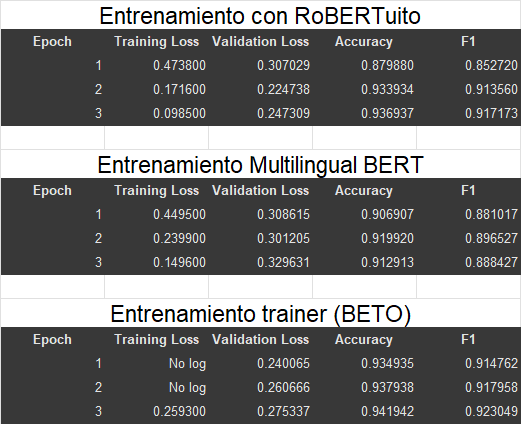

**Resultados comparativos de modelos:**

1. **BETO (Mejor desempeño):**
   - Destaca como el modelo óptimo en esta evaluación
   - Alcanza métricas sobresalientes:
     * F1-macro: 0.923
     * Accuracy: 0.941
   - Demuestra la ventaja de los modelos pre-entrenados específicamente para español

2. **RoBERTuito (Alternativa eficiente):**
   - Ofrece un balance ideal entre rendimiento y eficiencia
   - Presenta resultados competitivos con menor costo computacional
   - Opción recomendada cuando se prioriza la relación rendimiento-recursos

3. **Multilingual BERT:**
   - Muestra capacidad competitiva pero limitada
   - Queda por debajo de los modelos especializados en español
   - Efectivo para escenarios multilingües, pero no óptimo para español puro

**Conclusión:** La especialización lingüística (BETO y RoBERTuito para español) supera claramente a enfoques multilingües en este caso de uso, con BETO liderando el ranking de desempeño global.

##Predicciones sobre el test

Enumeración los checkpoints del modelo elegido

In [ ]:
ruta = "./beto_results"
checkpoints = [d for d in os.listdir(ruta) if d.startswith("checkpoint-")]
print(checkpoints)

Emumeración de los datos almacenados

In [ ]:
for checkpoint in checkpoints:
    path = os.path.join(ruta, checkpoint, "trainer_state.json")
    if os.path.exists(path):
        with open(path) as f:
            state = json.load(f)
            if "log_history" in state:
                for log in state["log_history"]:
                    if "eval_f1" in log:
                        print(f"{checkpoint} -> F1: {log['eval_f1']}")

Se carga el mejor modelo y el tokenizado entrenado

In [ ]:
# Cargo el modelo ENTRENADO desde el mejor checkpoint
mejor_checkpoint = "./beto_results/checkpoint-525"
model = AutoModelForSequenceClassification.from_pretrained(mejor_checkpoint)

# Cargo el tokenizer desde el modelo base (NO desde el checkpoint)
modelo_beto = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(modelo_beto)

Clase para dataset de predicción SIN labels

In [ ]:
class TweetDatasetPredict(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

Tokenización de los textos

In [ ]:
test_encodings = tokenizer(
    list(dataset_test_df["text_clean"]),
    truncation=True,
    padding=True
)

test_dataset = TweetDatasetPredict(test_encodings)

Se crea objeto trainer

In [ ]:
trainer = Trainer(model=model)

Se hacen las predicciones

In [ ]:
pred = trainer.predict(test_dataset)
y_pred = np.argmax(pred.predictions, axis=1)

Se crea DataFrame df_predicciones

In [ ]:
df_predicciones = dataset_test_df[["tweet_id"]].copy()
df_predicciones["label"] = y_pred

Guardar el archivo en formato

In [ ]:
df_predicciones.to_csv(
    'LEAL_MATA_JOSE_ANDRES_ejercicio1_predicciones_BETO.tsv',
    sep='\t',
    index=False,
    header=True
)

print("¡Predicciones generadas y guardadas correctamente!")

Se exporta archivo

In [ ]:
#from google.colab import files
#files.download('LEAL_MATA_JOSE_ANDRES_ejercicio1_predicciones_BETO.tsv')